In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error




In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [5]:
#loading dataset 
data = pd.read_csv("C:\\projects\\house_price_project\\melb_data.csv")

In [6]:
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [7]:
data['Address'].nunique()

13378

In [8]:
data.isna().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

In [10]:
class pricepersqrft(BaseEstimator, TransformerMixin):

    def __init__(self, size_col='Landsize', price_col='Price'):
        self.size_col = size_col
        self.price_col = price_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['price_per_sqrft'] = X.apply(
            lambda row: row[self.price_col] / row[self.size_col]
            if pd.notnull(row[self.size_col]) and pd.notnull(row[self.price_col]) and row[self.size_col] > 0 else np.nan,
            axis=1
        )
        return X


data = pricepersqrft(size_col='Landsize', price_col='Price').fit_transform(data)

In [11]:
#spliting data into train and testing data 

target = 'Price'

data = data.drop(columns='Address', errors='ignore')

features = [col for col in data.columns if col != target] 

x = data[features]
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

print(f"Train : {x_train.shape},Test: {x_test.shape}")

Train : (10864, 20),Test: (2716, 20)


In [12]:
x_train.isna().sum()

Suburb                0
Rooms                 0
Type                  0
Method                0
SellerG               0
Date                  0
Distance              0
Postcode              0
Bedroom2              0
Bathroom              0
Car                  50
Landsize              0
BuildingArea       5129
YearBuilt          4286
CouncilArea        1090
Lattitude             0
Longtitude            0
Regionname            0
Propertycount         0
price_per_sqrft    1568
dtype: int64

_______________________________________________________________________________________________________________________________________________________

###  FE

In [13]:
numerical_cols = ['Rooms','Bathroom','Bedroom2','Landsize','BuildingArea','Distance','price_per_sqrft']
categorical_cols  = ['Type','Method','Regionname']


In [14]:
print(numerical_cols)
print()
print(categorical_cols)
print()

['Rooms', 'Bathroom', 'Bedroom2', 'Landsize', 'BuildingArea', 'Distance', 'price_per_sqrft']

['Type', 'Method', 'Regionname']



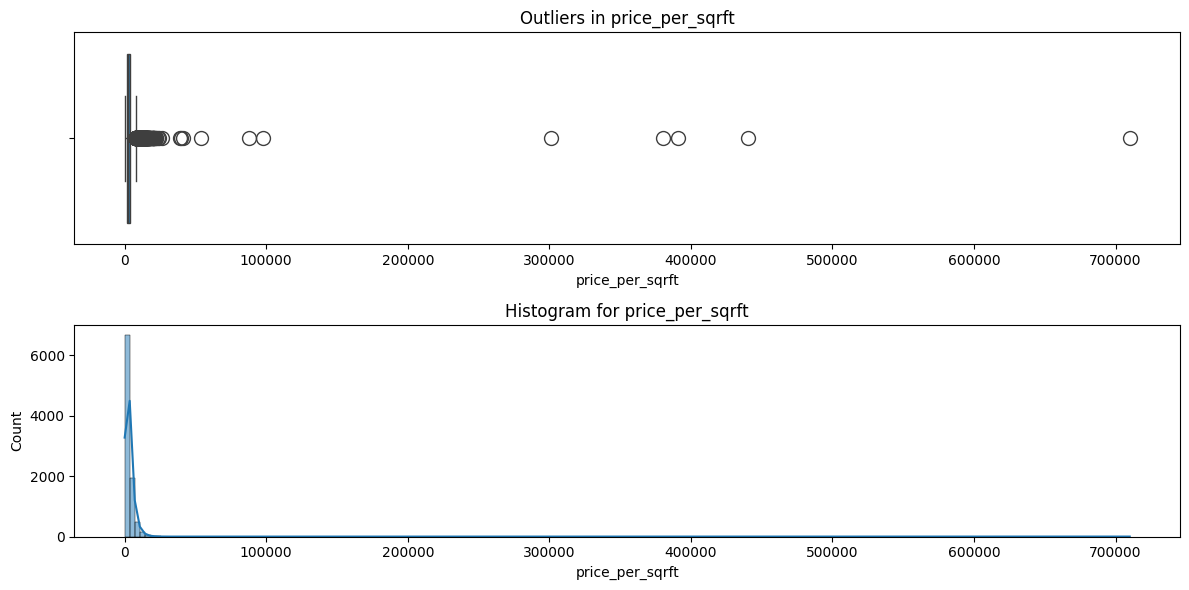

48.59368329240925


In [15]:
''' Visualizes outliers and distribution of a column using box plot and histogram, and checks skewness'''

def visualize_outliers(data,column,bins='auto',fliersize=10,kde=True):

    fig, axes = plt.subplots(2, 1, figsize=(12, 6))
    
    # Box Plot
    sns.boxplot(x=data[column], ax=axes[0], fliersize=fliersize)
    axes[0].set_title(f'Outliers in {column}')
    
    # Histogram
    sns.histplot(x=data[column], bins=bins, kde=kde, ax=axes[1])
    axes[1].set_title(f'Histogram for {column}')
    
    plt.tight_layout()
    plt.show()
    
visualize_outliers(x_train,'price_per_sqrft')

def skew_data(column):
    print(data[column].skew()) # >0 = Right Skewed, <0 = Left Skewed

skew_data('price_per_sqrft')


In [20]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]  
        return self

    def transform(self, X):
        X = np.clip(X, a_min=0, a_max=None)
        return np.log1p(X)


In [21]:

numerical_pipeline = Pipeline([

    ('imputer',SimpleImputer(strategy  = 'median')),
    ('scaler',LogTransformer())
])


categorical_cols_pipeline = Pipeline([

    ('imputer',SimpleImputer(strategy = 'constant',fill_value = 'missing')),
    ('encoder',OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
])


preprocessor = ColumnTransformer([

    ('num', numerical_pipeline, numerical_cols),
    ('cate',categorical_cols_pipeline,categorical_cols)
],remainder = 'drop')



________________________________________________________________________________________________________________________________________________________________


In [22]:
# Fit it
preprocessor.fit(x_train)

# Then transform
x_train_transformed = preprocessor.transform(x_train)
x_test_transformed = preprocessor.transform(x_test)


In [23]:
model = XGBRegressor(reg_alpha=1.0, reg_lambda=1.0, max_depth = 3, )
model.fit(
    x_train_transformed, y_train,
    eval_set=[(x_test_transformed, y_test)],
    verbose=False
)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,None
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_met

In [24]:
# Predict on train and test
y_train_pred = model.predict(x_train_transformed)
y_test_pred = model.predict(x_test_transformed)

# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# R²
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, R²: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}")


Train RMSE: 110367.68, R²: 0.9704
Test RMSE: 124653.06, R²: 0.9609


In [25]:
# saving model

import joblib

joblib.dump(model, "xgbboost_model.pkl")
joblib.dump(preprocessor, 'preprocessor.pkl')

loaded_model = joblib.load("xgbboost_model.pkl")